In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Initial condition is some distribution $f_0(r, \vec{v}) = f(r, \vec{v}, 0)$ (which can equivalently be expressed in terms of energy and angular momentum)

### Plummer model
### $\rho_P(r) = \frac{3M_0}{4\pi r_0^3}\left(1 + \frac{r^2}{r_0^2}\right)^{-5/2}$
### $\Phi_P(r) = \frac{GM_0}{\sqrt{r^2 + r_0^2}}$
### Black hole nuclear cluster
### $\Phi_{NC}(r) = \frac{GM_{\rm BH}}{r}$

### Energy / Angular Momentum Bounds
### $E = \Phi(r) - \frac{1}{2}v^2$
### $E_{\rm min} = 0$
### $E_{\rm max} = \Phi_P(r=0) = \frac{-GM_0}{r_0}$
### $R \equiv J^2/J_c^2$
### $J_c$ is the specific angular momentum of a circular orbit, so even though $J = J(E)$, $R$ is always bounded between $0$ and $1$
### $J = r|\hat{r}\times\vec{v}|$
### $R_{\rm min} = 0$
### $R_{\rm max} = 1$

### How to convert between code grid $E$, $R$ and physical position $r$, velocity vector $\vec{v}$?
### $N(E,R)dEdR = \int_{r_-}^{r_+} 4\pi r^2 dr(fd^3v)$ (Eq. 17 of Cohn+Kulsrud 1978)

In [2]:
def plummer_distribution(r, r0, M0):
    # https://en.wikipedia.org/wiki/Plummer_model#:~:text=The%20Plummer%20model%20or%20Plummer,body%20simulations%20of%20stellar%20systems.
    return (3*M0/(4*np.pi*r0**3.))*(1. + r*r/r0/r0)**(-5./2.)

def bh_potential(r, Mbh):
    return Mbh/r



In [3]:
def generate_distribution(rmin, rmax, r0, p_type='plummer', v_type='isotropic'):
    
    if p_type == 'plummer':
        rho = plummer_distribution(r, r0, 1)

### Equations 3-4 of of Takahashi 1995
### $A\frac{\partial f}{\partial t} = - \frac{\partial F_E}{\partial E} - \frac{\partial F_R}{\partial R}$
### $-F_E = D_{EE}\frac{\partial f}{\partial E} + D_{ER}\frac{\partial f}{\partial R} + D_E f$
### $-F_R = D_{RE}\frac{\partial f}{\partial E} + D_{RR}\frac{\partial f}{\partial R} + D_R f$
### Appendix C of Cohn 1979
### $D_{EE} = \frac{8\pi^2}{3}J_c^2(E) \int \frac{dr}{v_r}v^2(F_0 + F_2)$
### $D_E = -8\pi^2J_c^2(E) \int \frac{dr}{v_r}F_1$
### $D_{ER} = D_{RE} = \frac{16\pi^2}{3}J^2\int \frac{dr}{v_r} \left(\frac{v^2}{v_c^2} - 1\right)(F_0 + F_2)$
### $D_{RR} = \frac{16\pi^2}{3}R\int\frac{dr}{v^2}\left\{2\frac{r^2}{v^2}\left[v_t^2\left(\frac{v^2}{v_c^2} - 1\right)^2 + v_r^2\right]F_0 + 3\frac{r^2v_r^2}{v^2}F_1 + \frac{r^2}{v^2}\left[2v_t^2\left(\frac{v^2}{v_c^2}-1\right)^2 - v_r^2\right]F_2\right\}$
### $D_R    = -16\pi^2 R r_c^2 \int \frac{dr}{v_r}\left(1 - \frac{v_c^2}{v^2}\right)F_1$
### Appendix B of Cohn 1979
### $F_0(E,r) = 4\pi\Gamma \int_{-\infty}^E dE' \bar{f}(E',r)$
### $F_1(E,r) = 4\pi\Gamma \int_E^\phi dE'\bar{f}(E',r)\left(\frac{\phi - E'}{\phi - E}\right)^{1/2} = -4\pi\Gamma \left(\phi - E\right)^{-1/2}\int_\phi^E dE'\bar{f}(E',r)\left(\phi - E'\right)^{1/2}$
### $F_2(E,r) = 4\pi\Gamma \int_E^\phi dE'\bar{f}(E',r)\left(\frac{\phi-E'}{\phi - E}\right)^{3/2}$
### $\Gamma = 4\pi G^2m^2 {\rm ln}\Lambda$
### ${\rm ln}\Lambda$ ~ logarithmic cutoff factor (?)
### Equation 16 of Cohn 1979
### $\bar{f}(E,r) = \frac{1}{2R_{\rm max}^{1/2}}\int_0^{R_{\rm max}} \frac{dR}{(R_{\rm max} - R)^{1/2}}f(E,R)$
### $R_{\rm max}(E,r) = 2r^2[\Phi(r) - E]/J_c^2$

### We need to choose a radial grid to construct $\bar{f}(E,r)$. This will later be used if we solve the Poisson equation, as well. 
### For a Plummer potential we can follow Takahashi 1995, who take $r_{\rm min} = 10^{-8}\,r_0$ and $r_{\rm max} = 100\,r_0$, where $r_0$ is the core radius of the Plummer potential
### For a central SMBH, we can follow Cohn 1978, who ()

In [203]:
from scipy.integrate import trapz, cumtrapz

def calc_fbar(f,grid_r):
    
    grid_E = f.domain.grids[0]
    grid_R = f.domain.grids[1]
    fbar_domain = field.Domain((grid_E, grid_r))
    fbar = field.Field(fbar_domain)
    
    E_data = np.copy(grid_E.values)
    R_data = np.copy(grid_R.values)
    r_data = np.copy(grid_r.values)
    
    
    # Construct an integrand that is a 3D grid in (E, r, R) space; trapz() will integrate out the R dimension. 
    integrand_r = r_data[None,:,None]
    integrand_E = E_data[:,None,None]
    
    Jc   = np.sqrt(dpotential_dr(integrand_r)*integrand_r**3.)
    Rmax = 2*integrand_r*(potential(integrand_r)-integrand_E)/Jc**2.
    
    # R varies from 0 to Rmax. Assume R grid starts at 0!
    integrand_R = R_data[None,None,:]
    integrand_f = f.values[:,None,:] # add middle axis to f for r dimension
    integrand = (integrand_R<Rmax)*integrand_f/(Rmax - integrand_R)**0.5
    
    # for output data
    np.copyto(fbar.data, (1./2./Rmax[:,:,0]**0.5)*trapz(integrand, integrand_R, axis=-1))
    
    return fbar

def calc_F012(fbar):
    Lambda = 0.4*self.N
    Gamma = 4*pi*G*G*m*m*np.log(Lambda) # Lambda ~ logarithmic cutoff factor, G ~ gravitational constant, m ~ mass of individual star
    
    grid_E = fbar.domain.grids[0]
    grid_r = fbar.domain.grids[1]    
 
    # Check to make sure arrays dont occupy same place in memory. the '[:]' part does this for us, I think?
    E_data = np.copy(grid_E.values)
    Eprime_Data = np.copy(E_data)
    r_data = np.copy(grid_r.values)
    pot = potential(r_data)[None,:,None]

    ### F0
    F0_integrand = np.copy(fbar.data)*(Eprime_data[None,None,:]<E_data[:,None,None])
    F0 = 4*np.pi*Gamma*trapz(F0_integrand, Eprime_data[None,None,:],axis=-1)
    
    ### F1
    F1_integrand = fbar.data * ((pot - Eprime_data[None,None,:])/(pot - E_data[:,None,None]))**(0.5)
    F1 = 4*np.pi*Gamma*trapz(F1_integrand, Eprime_data[None,None,:],axis=-1)
    
    ### F2
    F2_integrand = fbar.data * ((pot - Eprime_data[None,None,:])/(pot - E_data[:,None,None]))**(1.5)
    F2 = 4*np.pi*Gamma*trapz(F2_integrand, Eprime_data[None,None,:],axis=-1)    
    
    return F0, F1, F2

def calc_diffusion_coefficients(f, fbar, F0, F1, F2):
    grid_E = fbar.domain.grids[0]
    grid_R = f.domain.grids[1]
    grid_r = fbar.domain.grids[1]
    
    E = grid_E[:,None,None]
    R = grid_R[None,:,None]
    r = grid_r[None,None,:]
    
    # Need to calculate: vc, vt, vr, v, Jc, J
    Jc   = np.sqrt(dpotential_dr(r)*r**3.) # angular momentum of circular orbit at given radius
    rc   = E/(2*G*M)                       # circular radius associated with E (E is the negative specific energy, i.e. is positive for all bound orbits)
    # R = J/Jc
    J    = r*Jc                  # angular momentum
    pot  = potential(r)          # potential energy (positive)
    v2   = 2*(pot - E)           # total velocity squared
    vr   = (v2 - J*J/r/r)**(0.5) # radial velocity
    vt   = (v2 - vr*vr)**(0.5)   # tangential velocity
    vc   = Jc*Jc/rc/rc           # tangential velocity associated with a circular orbit
    
    # calculate integrals
    
    ## Appendix C of Cohn 1979
    # D_EE  
    D_EE_integrand = (1./vr)*v2*(F0[:,None,:]+F2[:,None,:])
    D_EE           = 8*np.pi*np.pi/3*Jc*Jc * trapz(D_EE_integrand, r, axis = -1)
    
    # D_E
    D_E_integrand  = F1[:,None,:]/vr
    D_E            = -8.*np.pi*np.pi*Jc*Jc * trapz(D_E_integrand, r, axis = -1)
    
    # D_ER
    D_ER_integrand = (v2/vc/vc - 1)/vr * (F0[:,None,:]+F2[:,None,:])
    D_ER           = 16*np.pi*np.pi/3.*J*J * trapz(D_ER_integrand, r, axis = -1)
    
    # D_RR
    D_RR_integrand = (1./v2)*(2*r*r/v2 * ( vt*vt*(v2/vc/vc - 1)**2. + vr*vr)*F0[:,None,:] + 3*r*r*vr*vr/v2*F1[:,None,:] + r*r/v2*(2*vt*vt*(v2/vc/vc - 1)**2. - vr*vr)*F2[:,None,:])
    D_RR           = 16*np.pi*np.pi/3. * R * trapz(D_RR_integrand, r, axis = -1)
    
    # D_R
    D_R_integrand  = (1./vr)*(1. - vc*vc/v2)*F1[:,None,:]
    D_R            = -16*np.pi*np.pi*R*rc*rc * trapz(D_R_integrand, r, axis = -1)
    
    return D_EE, D_E, D_ER, D_RR, D_R

In [8]:
x = np.arange(0,10)
y = np.arange(0,10)

print(x,y)
X, Y = np.meshgrid(x,y)

R = 1./(1. + Y**2.)


from scipy.integrate import trapz

#print(R.shape)
#print(X.shape)

#print(trapz(np.ones(np.shape(x)),x))

I = trapz(np.ones(np.shape(X)), X,axis=-1)

print(X)
print(I)
print(I.shape)

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
(10,)


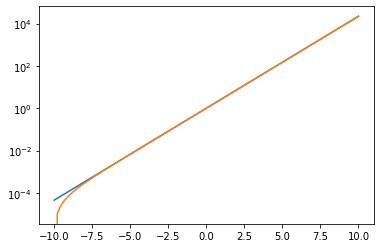

In [32]:
from scipy.integrate import cumtrapz,trapz
Egrid = np.linspace(-10,10,100)

fbar = np.exp(Egrid[None,:])

solution   = np.copy(fbar[0,:])
integrated = cumtrapz(fbar, Egrid,initial=0)[0,:]

plt.plot(Egrid,solution)
plt.plot(Egrid,integrated)
plt.yscale('log')

[0 0 0 0 0 0 0 0 0 0]


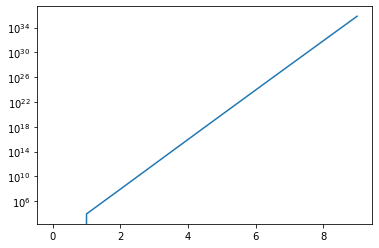

In [42]:
from scipy.integrate import cumtrapz,trapz
Egrid   = np.arange(0,10)#np.linspace(-10,10,100)
Egrid_p = np.arange(0,10)#np.linspace(10,10,100)

Egrid_both = Egrid[:,None]*Egrid_p[None,:]
print(Egrid_both[:,0])

fbar = np.exp(Egrid_both)



solution   = np.exp(Egrid)
integrated = trapz(fbar, Egrid_both)

#plt.plot(Egrid,solution)
plt.plot(Egrid,integrated)
plt.yscale('log')

In [64]:
x = np.arange(0,10)[:,None,None]
y = np.arange(10,20)[None,:,None]
z = np.arange(20,30)[None,None,:]
print(x,y,z)
print(x*y*z)

[[[0]]

 [[1]]

 [[2]]

 [[3]]

 [[4]]

 [[5]]

 [[6]]

 [[7]]

 [[8]]

 [[9]]] [[[10]
  [11]
  [12]
  [13]
  [14]
  [15]
  [16]
  [17]
  [18]
  [19]]] [[[20 21 22 23 24 25 26 27 28 29]]]
[[[   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0]]

 [[ 200  210  220  230  240  250  260  270  280  290]
  [ 220  231  242  253  264  275  286  297  308  319]
  [ 240  252  264  276  288  300  312  324  336  348]
  [ 260  273  286  299  312  325  338  351  364  377]
  [ 280  294  308  322  336  350  364  378  392  406]


### $\bar{f}(E,r) = \frac{1}{2R_{\rm max}^{1/2}}\int_0^{R_{\rm max}} \frac{dR}{(R_{\rm max} - R)^{1/2}}f(E,R)$


### $\int_0^{R_{\rm max}(r)} e^{E}e^{R} dR$
### $ e^{E} (e^{R_{\rm max}(r)} - 1) $

Rmax shape =  (1, 100, 1)
R shape =  (100,)
ind Rmax shape =  (1, 1000, 1)
[[[1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  ...
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]]
(100, 100, 100)
(100, 100)
(100, 100, 1)


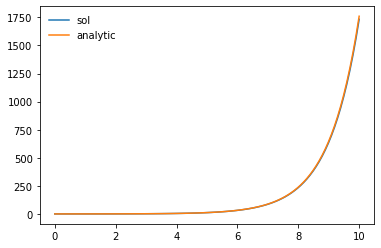

In [164]:
N = 100
E_data = np.linspace(0,10,N)
R_data = np.linspace(0,1,N)
r_data = np.linspace(10,100,N)##np.logspace(-2,2,N)

fbar   = np.exp(E_data[:,None,None])*np.exp(R_data[None,None,:])

# Construct an integrand that is a 3D grid in (E, r, R) space; trapz() will integrate out the R dimension. 
integrand_r = r_data[None,:,None]

Rmax = (0.5*integrand_r/np.max(integrand_r))**2.

print("Rmax shape = ", Rmax.shape)
print("R shape = ", R_data.shape)
print("ind Rmax shape = ", ind_Rmax.shape)
integrand_R = R_data[None,None,:]

#print(integrand_R.shape)
print(np.array(integrand_R<Rmax,dtype=int))
integrand = fbar*(integrand_R<Rmax)
print(integrand.shape)

#print(integrand.shape)
solution = trapz(integrand, integrand_R, axis=-1)
analytic = np.exp(E_data[:,None,None])*(np.exp(Rmax) - 1)
print(solution.shape)
print(analytic.shape)
#print(solution)

r_ind = N//2

plt.plot(E_data, solution[:,r_ind],label='sol')
plt.plot(E_data, analytic[:,r_ind],label='analytic')
plt.legend(loc='upper left', frameon=False)

### $F_0(E,r) = 4\pi\Gamma \int_{-\infty}^E dE' \bar{f}(E',r)$


### $\int_{0}^E dE' e^{2E'}r$
### $=0.5(e^{2E}-1)r$

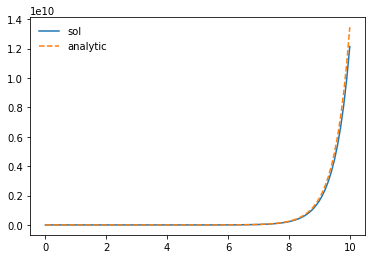

In [202]:
from scipy.integrate import trapz
N = 100
E_data = np.linspace(0,10,N)
Eprime_data = np.copy(E_data)
r_data = np.linspace(10,100,N)

fbar   = np.exp(2*Eprime_data[None,None,:])*r_data[None,:,None]*(Eprime_data[None,None,:]<E_data[:,None,None])

solution = trapz(fbar, Eprime_data[None,None,:],axis=-1)

analytic = 0.5*(np.exp(2*E_data[:,None]) - 1)*r_data[None,:]

r_ind = N//2

plt.plot(E_data, solution[:,r_ind],label='sol')
plt.plot(E_data, analytic[:,r_ind],label='analytic',ls='--')
plt.legend(loc='upper left', frameon=False)

(100, 100)


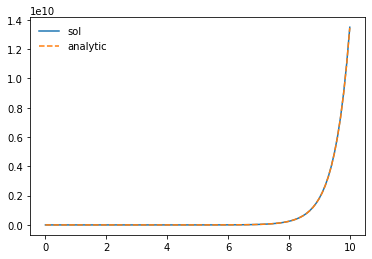

In [197]:
from scipy.integrate import cumtrapz
N = 100
E_data = np.linspace(0,10,N)
r_data = np.linspace(10,100,N)##np.logspace(-2,2,N)

fbar   = np.exp(2*E_data[:,None])*r_data[None,:]

solution = cumtrapz(fbar, E_data,axis=0,initial=0)
print(solution.shape)
analytic = 0.5*(np.exp(2*E_data[:,None]) - 1)*r_data[None,:]

r_ind = N//2

plt.plot(E_data, solution[:,r_ind],label='sol')
plt.plot(E_data, analytic[:,r_ind],label='analytic',ls='--')
plt.legend(loc='upper left', frameon=False)

### $\int_{0}^E dE' e^{2E'}$
### $=0.5(e^{2E}-1)$

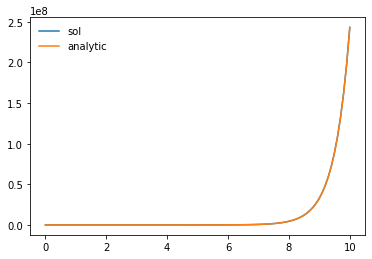

In [183]:
from scipy.integrate import cumtrapz
N = 100
E_data = np.linspace(0,10,N)

fbar   = np.exp(2*E_data)

solution = cumtrapz(fbar, E_data,initial=0)
analytic = 0.5*(np.exp(2*E_data) - 1)


plt.plot(E_data, solution,label='sol')
plt.plot(E_data, analytic,label='analytic')
plt.legend(loc='upper left', frameon=False)

### $F_1(E,r) = 4\pi\Gamma \int_E^\phi dE'\bar{f}(E',r)\left(\frac{\phi - E'}{\phi - E}\right)^{1/2}$

### $\int_E^{E_{\rm max}(r)} dE' e^{2E'}r(\frac{E_{\rm max}(r)-E'}{E_{\rm max}(r)-E})^{1/2}$

### $-\int^E_{\phi(r)} e^{-2E'}dE' = 0.5(e^{-2(E)} - e^{-2\phi(r)})$
### $\phi(r) > E$ at a given radius
### $\phi(r) \equiv E + (r/r_{\rm max})$

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [8.17078421e-01 8.17078421e-01 8.17078421e-01 ... 8.17078421e-01
  8.17078421e-01 8.17078421e-01]
 [6.67617146e-01 6.67617146e-01 6.67617146e-01 ... 6.67617146e-01
  6.67617146e-01 6.67617146e-01]
 ...
 [3.08732877e-09 3.08732877e-09 3.08732877e-09 ... 3.08732877e-09
  3.08732877e-09 3.08732877e-09]
 [2.52258972e-09 2.52258972e-09 2.52258972e-09 ... 2.52258972e-09
  2.52258972e-09 2.52258972e-09]
 [2.06115362e-09 2.06115362e-09 2.06115362e-09 ... 2.06115362e-09
  2.06115362e-09 2.06115362e-09]]


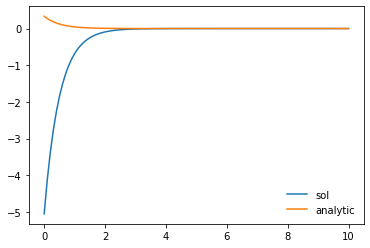

In [196]:
from scipy.integrate import cumtrapz
N = 100
E_data = np.linspace(0,10,N)
r_data = np.linspace(10,100,N)##np.logspace(-2,2,N)

fbar   = np.exp(-2*E_data[:,None])
phi    = E_data[:,None] + r_data[None,:]/np.max(r_data)


integrand = fbar*(E_data[:,None]<phi)
print(integrand)

solution = -1*cumtrapz(integrand, E_data, initial=0)
analytic = 0.5*(np.exp(-2*E_data[:,None]) - np.exp(-2*phi))

r_ind = N//2

plt.plot(E_data, solution[:,r_ind],label='sol')
plt.plot(E_data, analytic[:,r_ind],label='analytic')
plt.legend(loc='lower right', frameon=False)